In [192]:
import pandas as pd
import numpy as np
import networkx as netx
from pydantic import BaseModel
from typing import List
from collections import defaultdict
import matplotlib.pyplot as plt

In [207]:
# Traigo informacion de los nodos y los ejes
nodos_df= pd.read_csv('/Users/nicolassotelo/Desktop/deep_learning/data_erv_aggregated.csv')
ejes_df=pd.read_csv('/Users/nicolassotelo/Desktop/deep_learning/Conexiones_mod.csv')
graf=netx.MultiGraph()

In [ ]:
#Defino clases para los nodos y ejes
class NodeElectrica(BaseModel):
    nombre_central:str
    tipo:List[str]
    pronostico:List[float]


In [198]:
def create_graph(grafo:netx.Graph)->netx.Graph:
    for _,y in ejes_df.iterrows():
        entrada=y['ENTRADA']
        salida= y['SALIDA']
        barra=y['ID_BARRA']
        grafo.add_edge(entrada,salida,barra=barra)   
    return grafo     

In [186]:
#cramos los nodos
def add_info_graph(grafo:netx.Graph,var_tiempo:str)->netx.Graph:
    tiempo=var_tiempo
    filtrados_df=(nodos_df.loc[lambda df_:df_.datetime.astype(str)==tiempo,['region_nombre','tipo_central_nombre','pronostico']]).set_index('region_nombre')
    # construccion nodos y conexiones
   
    for region, data in filtrados_df.iterrows():
        tipo_central = data['tipo_central_nombre']
        pronostico = data['pronostico']
        if grafo.has_node(region):
            if 'informacion' not in grafo.nodes[region]:
                grafo.nodes[region]['informacion'] = {}
            grafo.nodes[region]['informacion'][tipo_central] = pronostico
    return grafo
    


In [208]:
grafo=create_graph(graf)
grafo=add_info_graph(grafo,'2021-09-05 18:00:00')

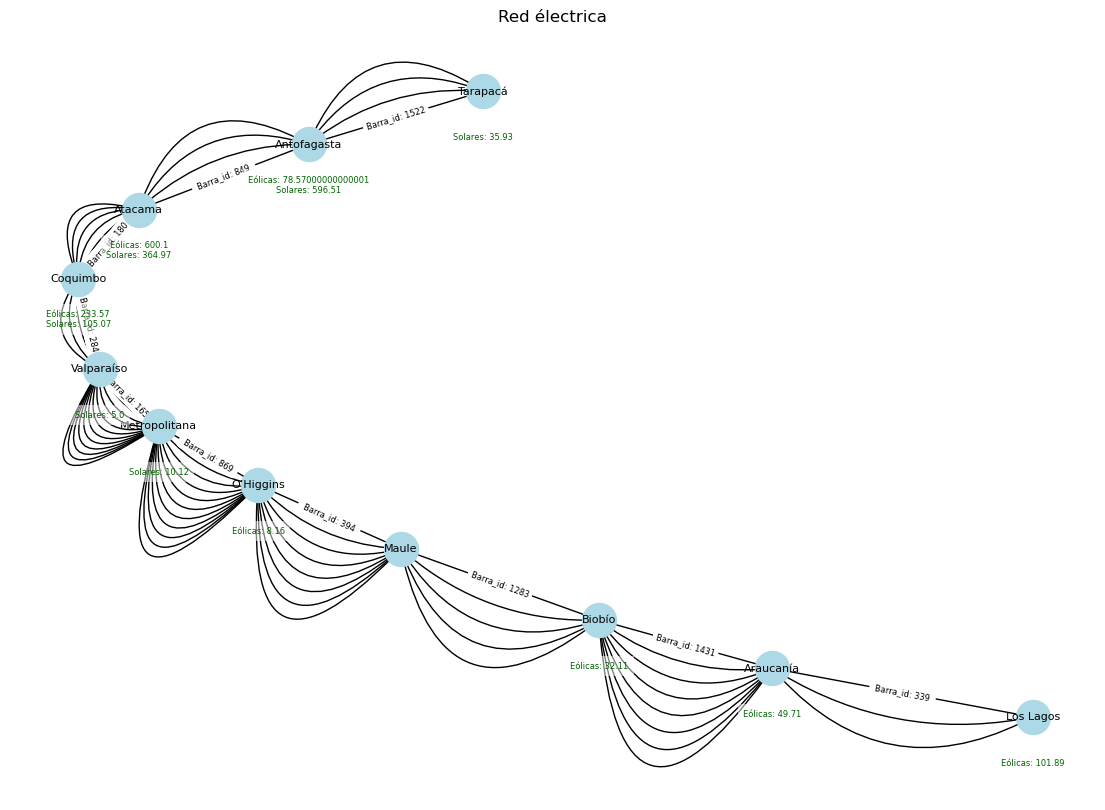

In [224]:
# Configurar la posición de los nodos usando spring_layout
pos = netx.spring_layout(grafo, k=0.6, seed=42)

# Ajustar el tamaño del gráfico
plt.figure(figsize=(14, 10))  # Incrementar el tamaño de la figura

# Dibujar nodos con tamaño reducido
netx.draw_networkx_nodes(grafo, pos, node_color="lightblue", node_size=600)

# Dibujar etiquetas de los nodos
netx.draw_networkx_labels(grafo, pos, font_size=8)

# Dibujar todas las aristas con separación
for u, v, key, data in grafo.edges(keys=True, data=True):
    netx.draw_networkx_edges(
        grafo, pos,
        edgelist=[(u, v)],
        connectionstyle=f"arc3,rad={0.2 * key}",  # Usa el índice `key` para curvar las aristas
        edge_color="black"
    )

# Añadir etiquetas de las aristas mostrando ambos atributos ('tipo' y 'peso')
edge_labels = {
    (u, v, key): f"Barra_id: {data['barra']}"
    for u, v, key, data in grafo.edges(keys=True, data=True)
}
netx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels, font_size=6)

# Mostrar la información de cada nodo como etiquetas adicionales
for nodo, datos in grafo.nodes(data=True):
    informacion = datos.get("informacion", {})
    info_str = "\n".join([f"{k}: {v}" for k, v in informacion.items()])
    x, y = pos[nodo]
    plt.text(x, y - 0.15, info_str, fontsize=6, ha="center", color="darkgreen", bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Título y ajustes finales
plt.title("Red électrica")
plt.axis("off")
plt.show()